# Behavioral Cloning for Udacity Drive Simulator

## This Project was prepared for Udacity Self Driving Car ND - Term one. 12 Feb 2019

Notes:

Project Uses Nvidia model published in NVIDIA End To End Driving Paper - Thanks and Acknowledgements

There are two environments. One for Drive simulator Model building Environment (this file) and second environment is for simulation interface bridge for realtime simulation (drive.py)

I have used two different workstations, a mac and a tensorflow gpu on windows 10 pro Xeon W workstation on GPU 1080, unfortunately this environment broke down with pip issues when installing pip (12.0 - relased Feb 2019 )along with eventlet and socket io which we use for drive.py.
I switched between mac dual core mojave tensorflow cpu (conda based). I finished off in mac.
Final movie is edited in apple imove. Music track is americal naitive pipe.

There are two ipnyb jupyter notebooks. One shows all the experiments from the start and this one is the second notebook where i finalised a model for final testing and submission


Date:12 Feb 2019

Change request for release : 1

Release no:

Prepared for : Udacity ND Term 1 BC

Prepared by : ARV

Design doc ref:

Release doc ref:

Tech doc ref:

Testing doc ref:

User Read me ref :

Admin and Dev read me ref:
    

In [45]:
!conda list

# packages in environment at /miniconda3/envs/udrivesimul:
#
# Name                    Version                   Build  Channel
absl-py                   0.7.0                 py36_1000    conda-forge
appnope                   0.1.0            py36hf537a9a_0  
asn1crypto                0.24.0                py36_1003    conda-forge
astor                     0.7.1                      py_0    conda-forge
backcall                  0.1.0                    py36_0  
blas                      1.0                         mkl    anaconda
bleach                    3.1.0                    pypi_0    pypi
bzip2                     1.0.6             h1de35cc_1002    conda-forge
c-ares                    1.15.0            h1de35cc_1001    conda-forge
ca-certificates           2019.1.23                     0  
cairo                     1.14.12           h9d4d9ac_1005    conda-forge
certifi                   2018.11.29               py36_0  
cffi                      1.11.5          py36h342bebf_100

Let us do the imports. All the imports done were collected and collated here

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Handle the CSV file containing ref to snapshot of manual driving files simulating real cameras on a car

In [18]:
datadir = 'new_track'
columns =['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv('driving_log.csv',names=columns)
data.head


<bound method NDFrame.head of                                                  center  \
0     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
1     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
2     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
3     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
4     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
5     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
6     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
7     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
8     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
9     C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
10    C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
11    C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
12    C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
13    C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
14    C:\Users\Vijy\Desktop\new_track\IMG\center_201...   
15    C:\Users\Vijy\Deskto

Handle path data and verifing first few lines with 'head'

In [19]:
def path_leaf(path):
    head,tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

Plotting steering angle as bins between values of -1 and +1, against number of occurances in the training 

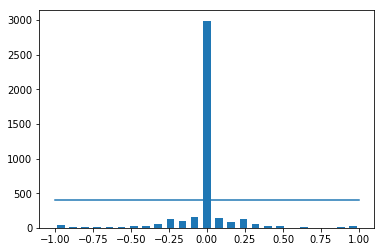

In [20]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Data study for feature enineering and data wrangling. 
Removing too much bias for 0 deg straight angle and attemting at generalising beyond this predominatly straight track road

In [21]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 4053
removed: 2590
remaining: 1463


Histogramming steering after removal

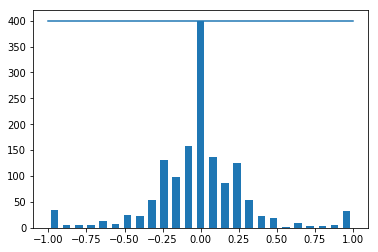

In [22]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Printing a sample and verifying data pattern

In [23]:
print(data.iloc[1])


center      center_2018_07_16_17_11_44_485.jpg
left          left_2018_07_16_17_11_44_485.jpg
right        right_2018_07_16_17_11_44_485.jpg
steering                                 -0.25
throttle                              0.863326
reverse                                      0
speed                                  2.17305
Name: 13, dtype: object


Function for picking up images and returning image paths and steering angle value from csv file

In [24]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

Adding real file system point for dataset. Spliting training and validation set from collected data

In [25]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

Printing out our training and validation split set, plotting histogram to visualise steering angles

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

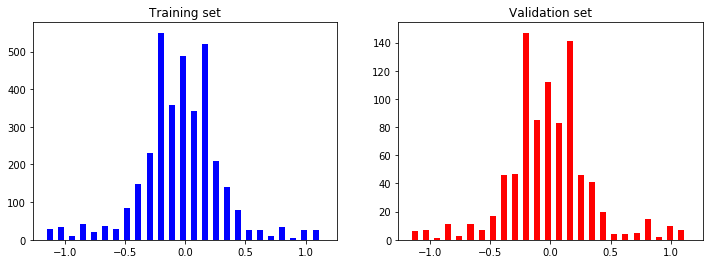

In [26]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


###### Augmentation Techniques

We attempt various augmentation methods to try and generalise trained model from the collected training data.

Zoom affine augmentation

In [27]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [28]:
print(image)

IMG/IMG/right_2018_07_16_17_11_47_988.jpg


Text(0.5, 1.0, 'Zoomed Image')

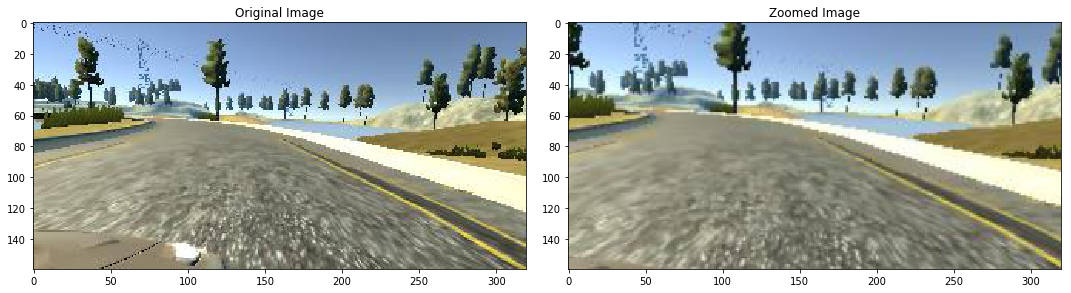

In [29]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Pan augmentation 

Text(0.5, 1.0, 'Panned Image')

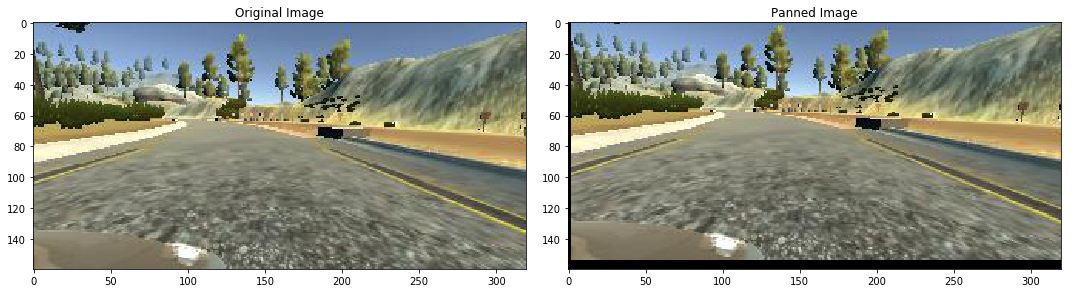

In [30]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Altered Brightess augmentation

Text(0.5, 1.0, 'Brightness altered image ')

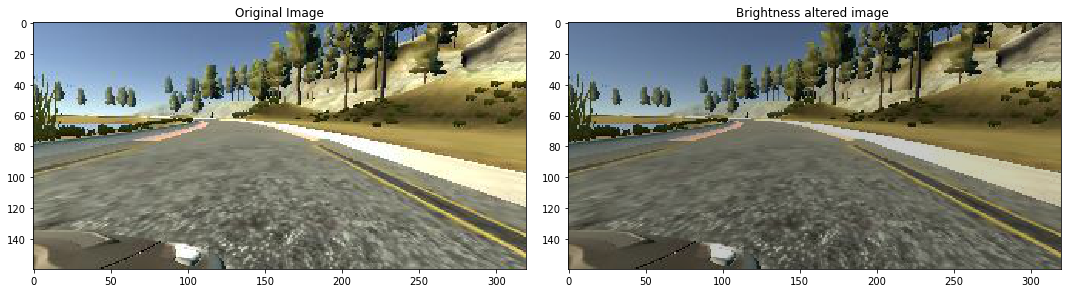

In [31]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Random Flip Augmentation

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

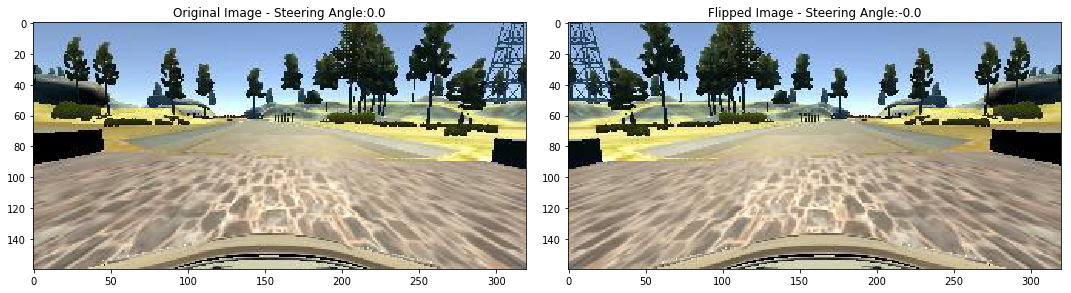

In [32]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

We do a 50% probablity for selective augmentation on various images

In [33]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

Preparing for plot areas to visualise augmentations

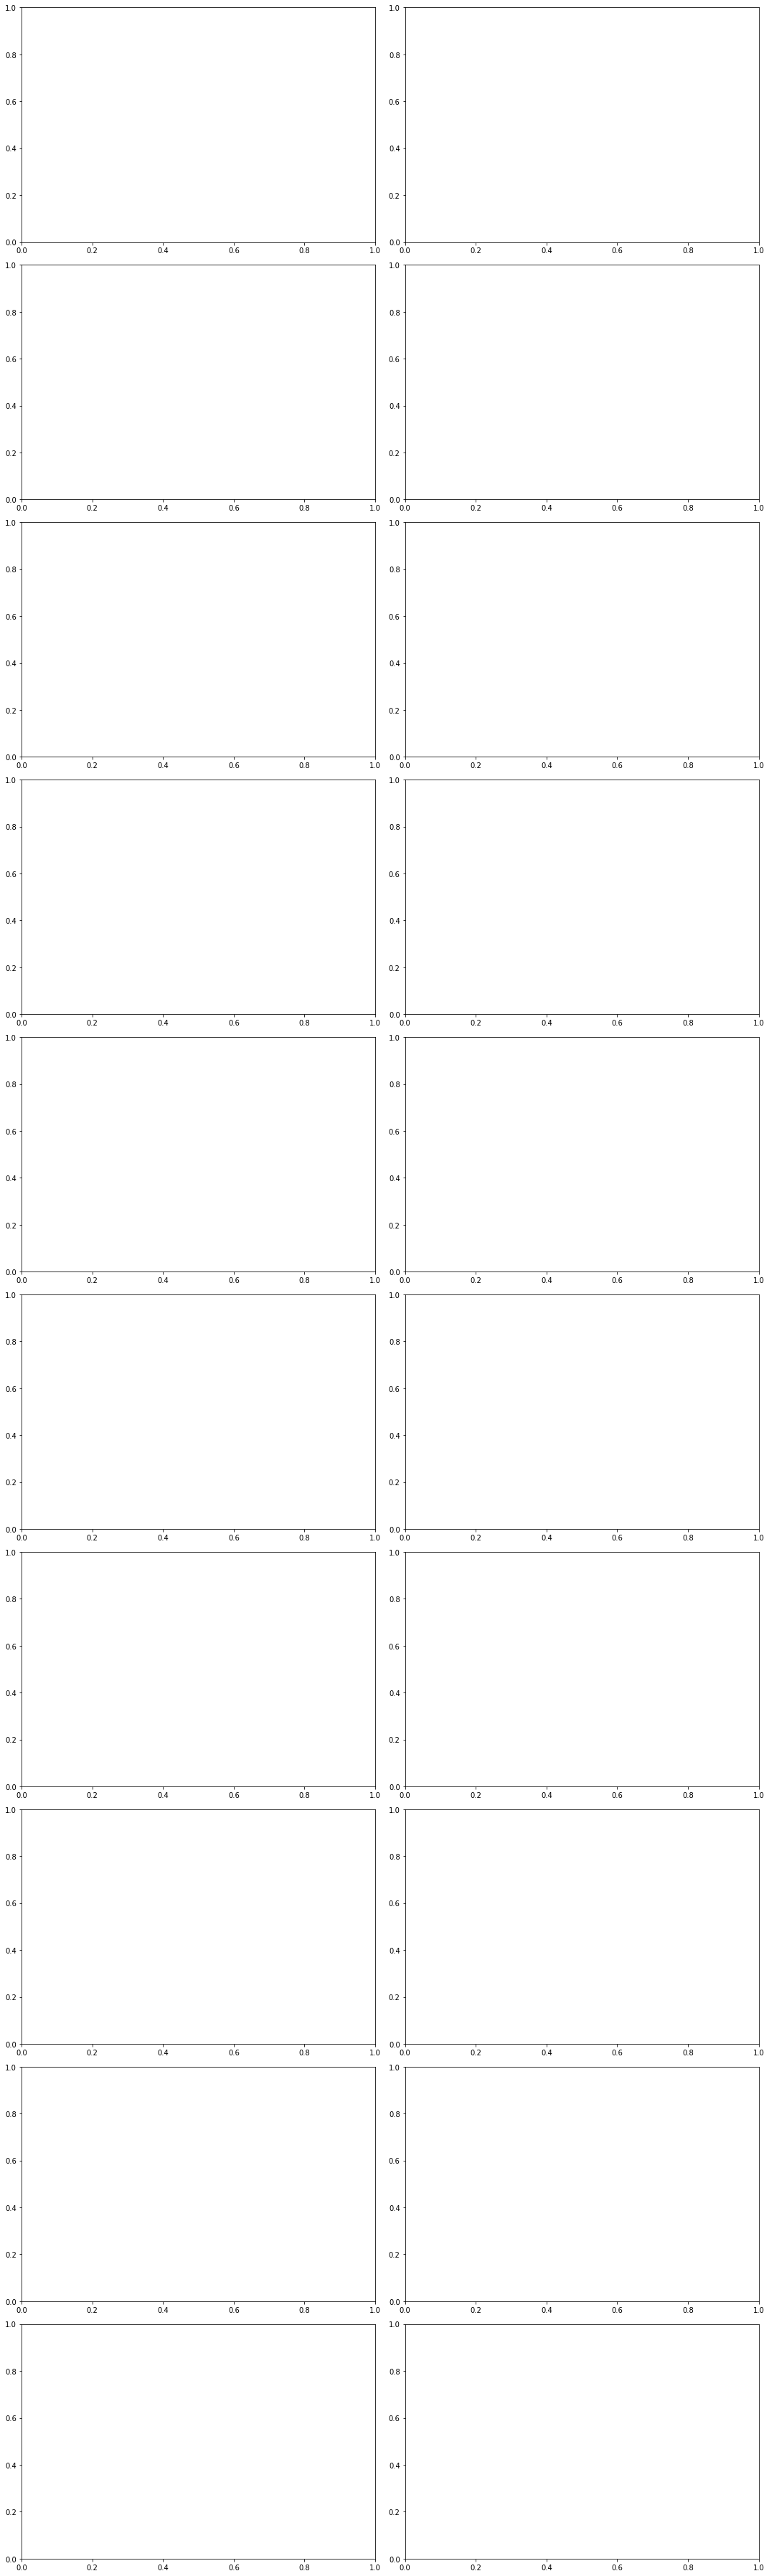

In [34]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

Augmentations visualised 

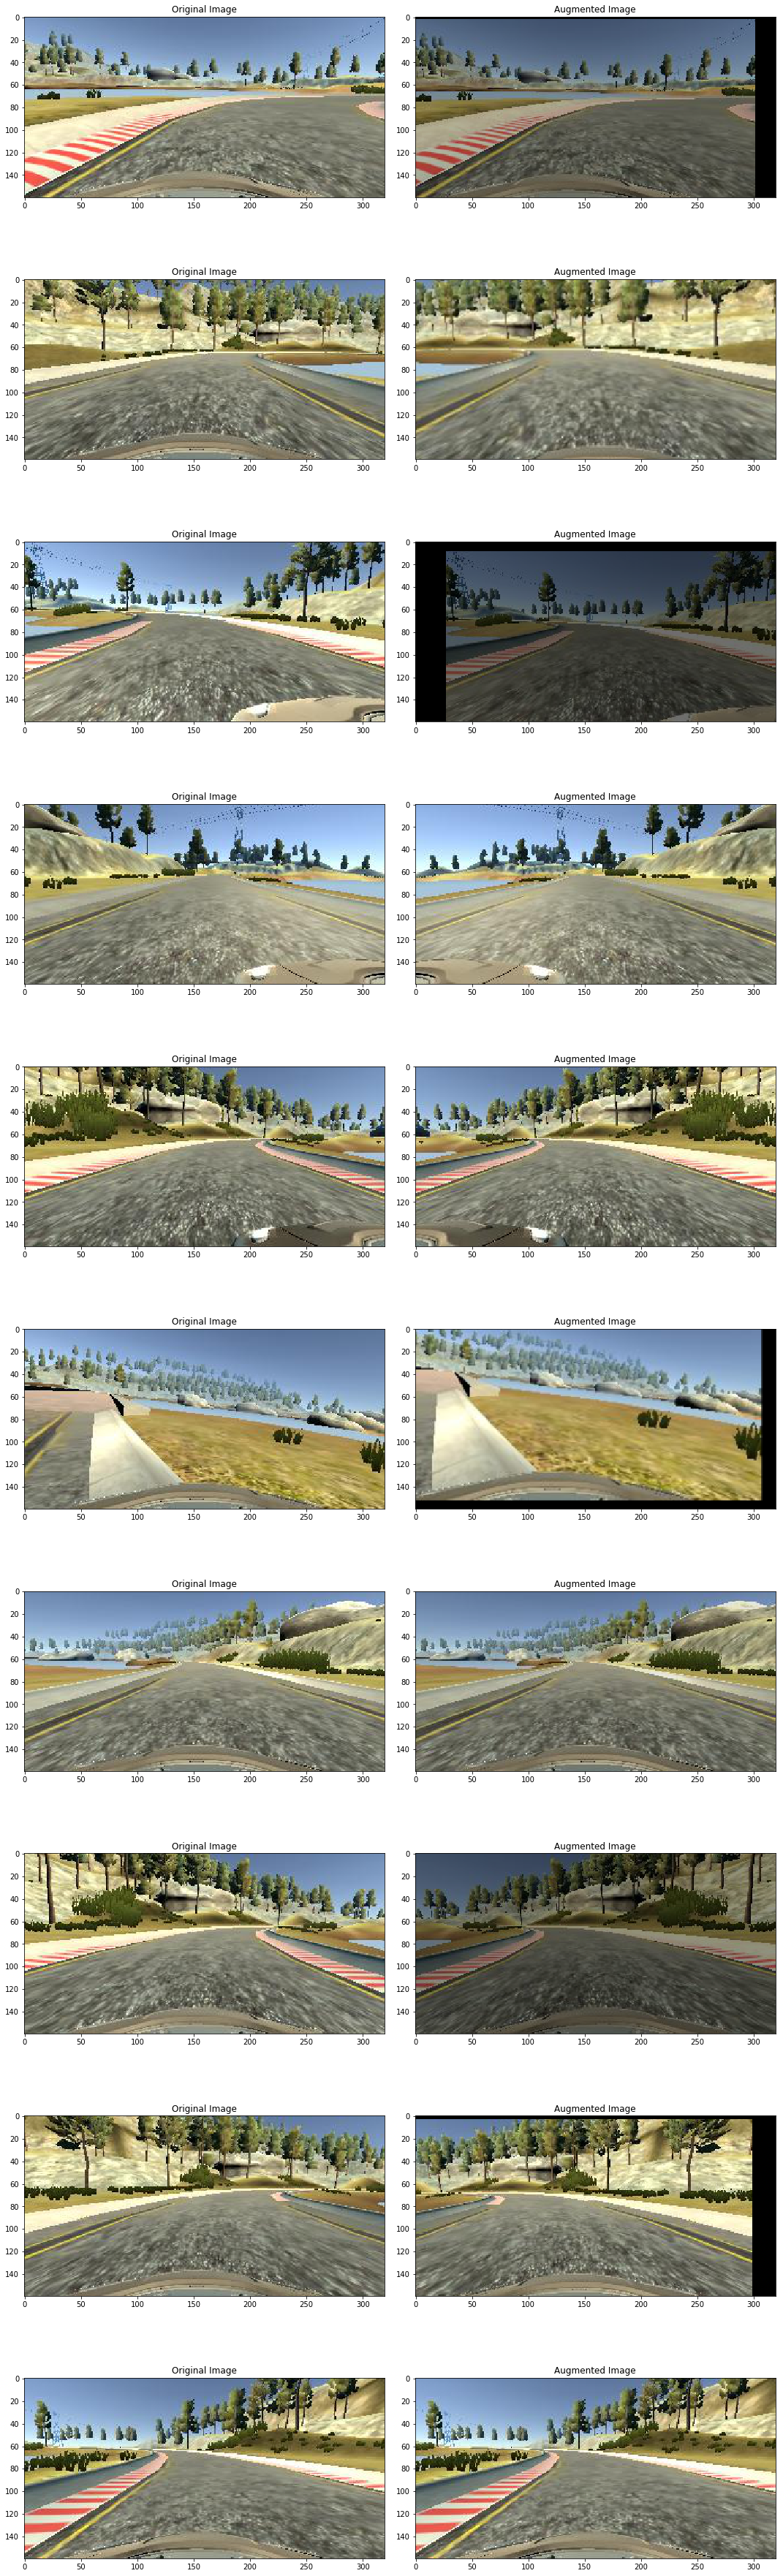

In [35]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Usual regular Preprocessing of RGB to YUV,Gauss Blurr, and resizing 

In [36]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

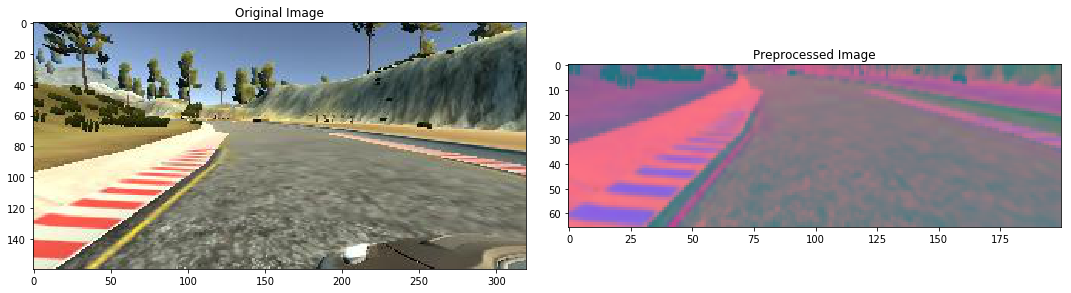

In [37]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

A Realtime batch processor with 'Yield' as return to handle realtime simulation

In [38]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Training in batches using batch generator 

In [39]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 

Attemting visual verification of training and validation image from batch generator output

Text(0.5, 1.0, 'Validation Image')

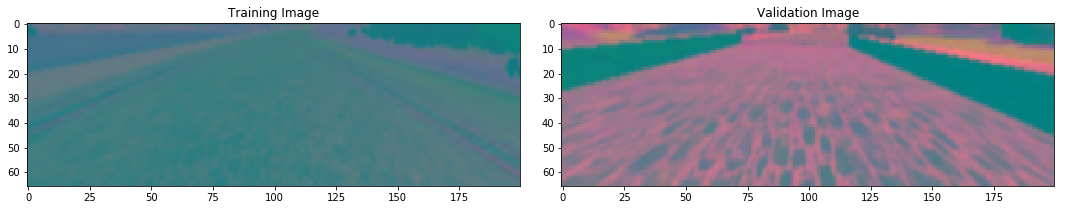

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

## Building NVIDIA Model 

Thanks to NVIDIA  for paper,figs & model are from two nvidia papers and references mentioned.
Fully acknowledged, appreciated and thanked for sharing with public.

Title :End to End Learning for Self-Driving Cars


REF :https://arxiv.org/pdf/1604.07316v1.pdf¶

##### I also found another interesting but advanced paper from NVIDIA
TItle : Explaining How a Deep Neural Network Trained with End-to-End Learning Steers a Car

https://arxiv.org/pdf/1704.07911.pdf

In [41]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

/miniconda3/envs/udrivesimul/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/miniconda3/envs/udrivesimul/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/miniconda3/envs/udrivesimul/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/miniconda3/envs/udrivesimul/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/miniconda3/envs/udrivesimul/lib/python3.6/site-packages/ipykernel_launche

Training Time

In [42]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 343s 1s/step - loss: 0.2325 - val_loss: 0.1145
Epoch 2/10
300/300 [==============================] - 334s 1s/step - loss: 0.1038 - val_loss: 0.0730
Epoch 3/10
300/300 [==============================] - 329s 1s/step - loss: 0.0758 - val_loss: 0.0586
Epoch 4/10
300/300 [==============================] - 330s 1s/step - loss: 0.0837 - val_loss: 0.0595
Epoch 5/10
300/300 [==============================] - 322s 1s/step - loss: 0.0675 - val_loss: 0.0577
Epoch 6/10
300/300 [==============================] - 330s 1s/step - loss: 0.0586 - val_loss: 0.0420
Epoch 7/10
300/300 [==============================] - 325s 1s/step - loss: 0.0531 - val_loss: 0.0393
Epoch 8/10
300/300 [==============================] - 333s 1s/step - loss: 0.0501 - val_loss: 0.0357
Epoch 9/10
300/300 [==============================] - 323s 1s/step - loss: 0.0479 - val_loss: 0.0356
Epoch 10/10
300/300 [==============================] - 332s 1s/step - loss: 0.0469 - val_lo

Plotting Model loss

Text(0.5, 0, 'Epoch')

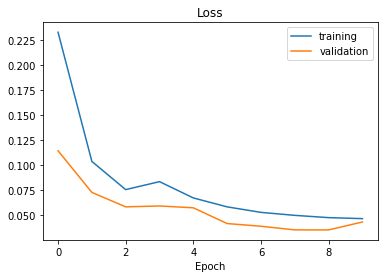

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Saving Model to File system.

In [44]:
model.save('selected_model_BC1.h5')

End